<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2020</span></p>
<p><font size="4">  UE OPTAI  </font></p>
<p></p>
<p><font size="5">  Notebook 03: Python lab - Proximal methods </font></p>
</p>
<p><font size="4">  Student Name: Zuoyu Zhang </font></p>
</p>
</br>
</p>
</CENTER>

$$ 
\def\R{{\mathbb R}} 
\def\N{{\mathbb N}} 
\def\Z{{\mathbb Z}} 
\def\Xm{{\bf X}}
\def\xv{{\bf x}}
\def\Ym{{\bf Y}}
\def\yv{{\bf y}}
\def\wv{{\bf w}}
\def\lambdav{{\bf \lambda}}
$$

## Part 1. Image denoising using proximal methods

Firstly, we give a noisy image $y\in \R_+^{n\times n}$ that is $$y = x + w \quad (1)$$ with $x\in \R^{n\times n}$ is the original image that we want to recover and $w\in \R^{n\times n}$ is a Gaussian additional white noise. 

The goal of this work is to denoising $y$ by using the promixal algorithms. 

In [ ]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise,Conv2D,BatchNormalization,Input,Dense,Add,ReLU,MaxPooling2D,Conv2DTranspose,Subtract,Dropout
from tensorflow.keras.models import Model
import numpy as np
import PIL
from IPython.display import Image
import matplotlib.pyplot as plt
import cv2
from numpy import linalg as la
from keras.models import model_from_json
import pandas as pd
import pathlib
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

#### Question 1: Load the Lena image and add to it a Gaussian white noise with variance $σ = 20$. Then show both original and noisy image 

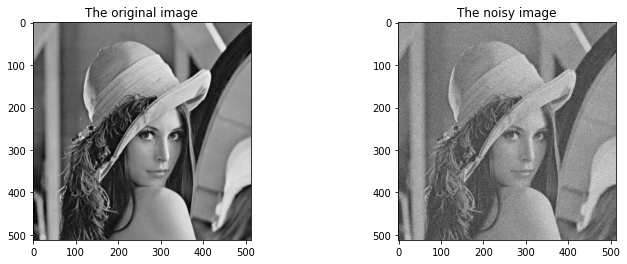

In [ ]:
img = cv2.imread('/content/lena.png', flags=0)
#Convertir l'image en un tableau(numpy array) de réels double
img = img.astype(np.float64)
#Ajouter le bruit gaussien à l'image originale
noise = np.random.normal(0, 20, img.shape)     
img_noise = img + noise
#Plot the original and noisy image
fig = plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.title("The original image")
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.title("The noisy image")
plt.imshow(img_noise, cmap='gray')
plt.show()

#### Question 2: Define gradient operator $D: \R^{n\times n}\to  \R^{n\times n\times 2}$ such that $\forall x\in\R^{n\times n},\quad (Dx)_{i,j,1} = x_{i,j} - x_{i-1,j}$,  gradient image in the $x$ direction measuring horizontal change in intensity, and  $(Dx)_{i,j,2} = x_{i,j} - x_{i,j-1}$, gradient image in the $y$ direction measuring vertical change in intensity.

In [ ]:
#Define gradient operator D with shape (2*m*n)
def grad_operator(x):
    m,n = x.shape
    grad_x = np.zeros((m,n,2))
    for i in range(0,m):
        for j in range(0,n):
            if(i!=0):
                grad_x[i,j,0] = x[i,j] - x[i-1,j]
            if(j!=0):
                grad_x[i,j,1] = x[i,j] - x[i,j-1]
    return grad_x

#### Question 3: Show the gradient images in both horizontal and vertical directions.

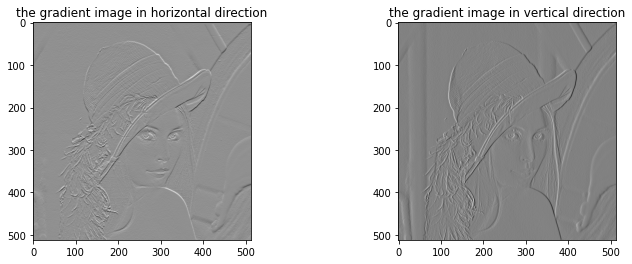

In [ ]:
grad_img = grad_operator(img)
fig = plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.title("the gradient image in horizontal direction")
plt.imshow(grad_img[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.title("the gradient image in vertical direction")
plt.imshow(grad_img[:,:,1], cmap='gray')
plt.show()

#### Question 4: Define the cost function $F(x)$ to be minimized allowing to solve the problem (1). Note that the total variational  is considered as a regularization term.

##### Our goal is to reconstruct the original image x from the observation y. We consider the optimization model
\begin{equation}
	\mathop{\arg\min}_x μ \| x - y\|^2 + λ\|\nabla x \|_P
\end{equation}
We try and define two kinds of loss functions, the first one adds L2 regular term, the second one adds L1 regular term, and the definitions of the two loss functions are as follows

$$F_1(x) = \frac{1}{2}||y-x||^2 + \lambda ||D_x||_2^2$$

$$F_2(x) = \frac{1}{2}||y-x||^2 + \lambda ||D_x||_1^1$$

#### Question5: Propose a proximal algorithm that solves your optimization problem 

### Adding L1 norm
For the first loss function, we added an L2 regularization term, which can be directly derived, so we used three algorithms: gradient descent and FOBOS. Below we explain the principles and steps of the algorithms one by one.

**Algorithm 1: Gradient Descent**

We compute the gradient of the loss function as follows

$$\nabla F_1(x) = x - y + 2 λ D^T(D_x)$$

The gradient descent algorithm uses the principle that the function drops fastest along the direction of the negative gradient. Each iteration calculates the gradient of the current loss function to update the optimization target x, thereby reducing the value of the loss function, achieving the purpose of optimization, and completing the noise reduction of the image. Proceed as follows:

Input : set $x_0 = y$ and initialize learning rate, λ and β

Output : $x_K$

1.   For k = 1 to K do
2.   >Compute the gradient G = $\nabla F_1(x_{k-1})$
3.   >Update x: $x_{k} = x_{k-1} - lr*G$
4.   >Update λ: λ = β*λ

End for

**Algorithm 2: Forward-backward splitting(FOBOS)**

In FOBOS, the update of weights is divided into two steps. The former step is actually a standard gradient descent step, and the latter step can be understood as fine-tuning the result of gradient descent. Proceed as follows:

Input : set $x_0 = y$ and initialize learning rate, λ and β

Output : $x_K$

1.   For k = 1 to K do
2.   >Update x: $x_{k} = prox_{γλ||D_x||_2^1}(x_{k-1} - γ∇f(x_{k-1}))$ with $f(x)=\frac{1}{2}||y-x||^2$
3.   >Update Dx: $Dx = prox_{λ||.||_2^1}Dx$
3.   >Update λ: λ = β*λ

End for

### Adding L2 norm
For the second loss function, we added an L1 regularization term, which can not be directly derived, so we used the dual problem to optimize and derivation process is as follows.

The original problem: 
\begin{equation}
	\mathop{\arg\min}_x \frac{1}{2} \| x - y\|^2 + λ\|D x \|_1
\end{equation}

We can write the dual problem as:
\begin{equation}
	\mathop{\arg\min}_z (\frac{1}{2} \| -λD^Tz - y\|^2)^* + λ\|z \|_1^*
\end{equation}

Firstly we want to calculate the conjugate function of $f(x) = \frac{1}{2} \| x - y\|^2$
\begin{equation}
	f(t) = \mathop{\sup}_x x^Tt- \frac{1}{2} \| x - y\|^2
\end{equation}

Let $g(x) = x^Tt- \frac{1}{2} \| x - y\|^2$, then $∇g(x)=t-x+y=0$, we get $x=t+y$, then we will get the formula

$$f(t) = (t+y)^Tt-\frac{1}{2} \|t+y-y\|^2=\frac{1}{2}\|t\|^2+y^Tt$$

So now we can reorganize the dual problem expression
\begin{equation}
	\mathop{\arg\min}_z \frac{1}{2} \| -λD^Tz\|^2 - λ(Dy)^Tz + λ\| z\|_1^*
\end{equation}

So the question is becoming the normal form as
\begin{equation}
	z = \mathop{minimize}_z f(z) + λ\| z\|_1^*
\end{equation} 

We can directly use the proximal descent gradient algorithm to optimize the dual problem.

**Algorithm 1: Proximal descent gradient**

Input : set $x_0 = y$ and initialize learning rate, λ

Output : $x_K$

1.   For k = 1 to K do
2.   >$∇f(z_{k-1}) = λ^2 D D^T(z_{k-1}) - λDy$
3.   >Update z: $z_{k} = prox_{γλ||.||_1^*}(z_{k-1} - γ∇f(z_{k-1}))$ 

End for

$x_K = D^T(z_K)$

#### Question 6: Define the cost funtions $F(x)$ to be minimized, the gradient or proximal operators that will be used in the algorithms.

### Add L2 regular term

In [ ]:
# Define the cost function
def fun_cost(x,y,lambda_reg):
    return lambda_reg * np.linalg.norm(D(x)) + 1/2 * np.linalg.norm(x - y)**2 

In [ ]:
#Define gradient operator D with shape (2*m*n)
def D(x):
    return np.array([x-np.vstack((x[1:,:], np.zeros((1,x.shape[1])))), x-np.hstack((x[:,1:], np.zeros((x.shape[0],1))))]) 
#Calculate the gradient of image
def Dadj(u):
    return u[0,:,:]-np.vstack((np.zeros((1,u.shape[2])),u[0,:-1,:]))+u[1,:,:]-np.hstack((np.zeros((u.shape[1],1)),u[1,:,:-1])) 

In [ ]:
def mse_loss(image, denoised_img):
  return np.linalg.norm(image - denoised_img)/(image.shape[0]*image.shape[1])

In [ ]:
#Define the denoising function with L2 regularization using descent gradient
def denoise_image_GD(image, learning_rate, num_iterations, lambda_reg, beta):
    denoised_image = image.copy()
    d_old = Dadj(D(denoised_image))
    for i in range(num_iterations):
      # The codition of convergence
      if np.linalg.norm(d_old)<np.linalg.norm(Dadj(D(denoised_image))):
        break
      else:
        # Compute the gradient of the cost function with L2 regularization
        gradient = denoised_image - image + 2*lambda_reg*Dadj(D(denoised_image))
        # Update the image pixel values
        d_old = Dadj(D(denoised_image))
        denoised_image -= learning_rate * gradient
        lambda_reg *= beta
    return denoised_image

In [ ]:
def denoise_image_FOBOS(image, lambda_reg, beta, num_iters=80, tau=0.1):
    # initialize x as the noisy image
    denoised_image = image.copy()
    # define the gradient operator
    Dx = Dadj(D(denoised_image))
    for i in range(num_iters):
        # calculate the gradient of the cost function
        grad = denoised_image - image + 2*lambda_reg*Dx
        # update x using the proximal operator of the L2 norm
        denoised_image -= tau*grad
        # calculate the gradient of the regularizer
        Dx = Dadj(D(denoised_image))
        # update Dx using the proximal operator of the L2 norm
        Dx /= np.maximum(np.abs(Dx), 1/lambda_reg)
        Dx *= np.maximum(np.abs(Dx) - 1/lambda_reg, 0)
        lambda_reg *= beta
    return denoised_image

### Add L1 regular term

In [ ]:
#Compute the proximal operator of the conjugate function of the L1 norm with regularization parameter sigma.
def prox_l1(v, sigma):
    return np.sign(v) * np.maximum(0, np.abs(v) - sigma)

In [ ]:
#Compute the proximal operator of the conjugate function of L1 norm for a matrix.
def prox_l1_conjugate(y, alpha):
    x = np.zeros_like(y)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            for k in range(y.shape[2]):
              if np.linalg.norm([y[i,j,k]], ord=np.inf) > alpha:
                  x[i,j,k] = y[i,j,k] - alpha*np.sign(y[i,j,k])
              else:
                  x[i,j,k] = 0
    return x

In [ ]:
def denoise_image_Dual_GD(image, lambda_reg, num_iters=100, tau=0.01):
    # initialize x as the noisy image
    z = D(image)
    for i in range(num_iters):
        # calculate the gradient of the cost function
        grad = lambda_reg**2 * D(Dadj(z)) - lambda_reg * D(image)
        # update z
        z -= tau*grad
        # update x using the proximal operator of the L1 norm conjugate
        z = prox_l1_conjugate(z, tau*lambda_reg)
    denoised_image = Dadj(z)
    return denoised_image

#### Question 7: Show the denoising image obtained and analyze it

In [ ]:
# Set hyperparameters
learning_rate = 0.005
num_iterations = 5000
lambda_reg = 1 #Regularization parameter
beta = 0.99

In [ ]:
# Apply gradient descent with L2 regularization
denoised_img = denoise_image_GD(img_noise, learning_rate, num_iterations, lambda_reg, beta)

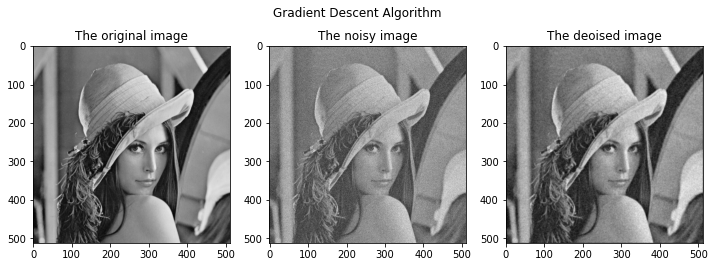

In [ ]:
# Display the denoised image
fig = plt.figure(figsize=(12, 4))
plt.suptitle('Gradient Descent Algorithm')
plt.subplot(1,3,1)
plt.title("The original image")
plt.imshow(img, cmap='gray')
plt.subplot(1,3,2)
plt.title("The noisy image")
plt.imshow(img_noise, cmap='gray')
plt.subplot(1,3,3)
plt.title("The deoised image")
plt.imshow(denoised_img, cmap='gray')
plt.show()

In [ ]:
print("The mse loss for descent gradient is", mse_loss(img, denoised_img))

The mse loss for descent gradient is 0.017428703676047957


In [ ]:
print("The psnr for descent gradient is", compare_psnr(img, denoised_img, data_range = 255))

The psnr for descent gradient is 29.120102667933025


In [ ]:
denoised_img = denoise_image_FOBOS(img_noise, 20, 0.99, num_iters=70, tau=0.015)

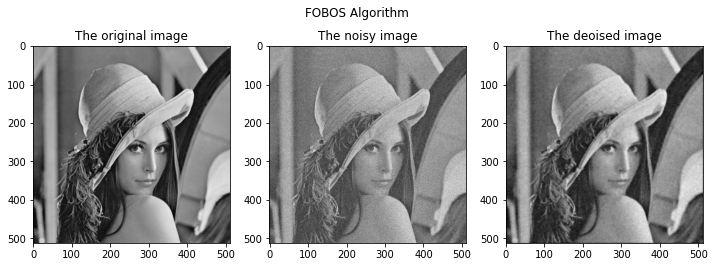

In [ ]:
# Display the denoised image
fig = plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.suptitle('FOBOS Algorithm')
plt.title("The original image")
plt.imshow(img, cmap='gray')
plt.subplot(1,3,2)
plt.title("The noisy image")
plt.imshow(img_noise, cmap='gray')
plt.subplot(1,3,3)
plt.title("The deoised image")
plt.imshow(denoised_img, cmap='gray')
plt.show()

In [ ]:
print("The mse loss for FOBOS is", mse_loss(img, denoised_img))

The mse loss for FOBOS is 0.016427953534618976


In [ ]:
print("The psnr for FOBOS is", compare_psnr(img, denoised_img, data_range = 255))

The psnr for FOBOS is 29.63373507296033


In [ ]:
denoised_img = denoise_image_Dual_GD(img_noise, lambda_reg = 1, num_iters=50, tau=0.01)

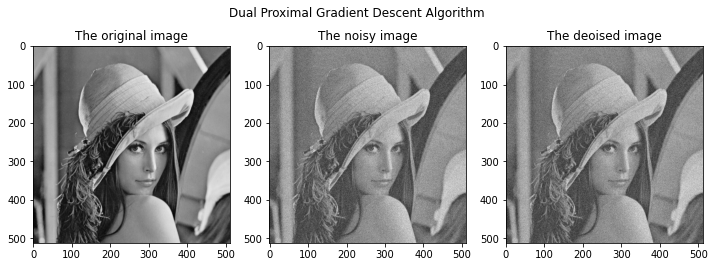

In [ ]:
# Display the denoised image
fig = plt.figure(figsize=(12, 4))
plt.suptitle('Dual Proximal Gradient Descent Algorithm')
plt.subplot(1,3,1)
plt.title("The original image")
plt.imshow(img, cmap='gray')
plt.subplot(1,3,2)
plt.title("The noisy image")
plt.imshow(img_noise, cmap='gray')
plt.subplot(1,3,3)
plt.title("The deoised image")
plt.imshow(img_noise, cmap='gray')
plt.show()

In [ ]:
print("The mse loss for dual problem solution is", mse_loss(img, denoised_img))

The mse loss for dual problem solution is 0.26123816747027123


In [ ]:
print("The psnr for dual problem solution is", compare_psnr(img, denoised_img, data_range = 255))

The psnr for dual problem solution is 5.604671816827741


In [ ]:
print("The mse loss between original image and noisy image",mse_loss(img, img_noise))

0.039085641037704316

In [ ]:
print("The psnr between original image and noisy image",compare_psnr(img, img_noise, data_range = 255))

The psnr between original image and noisy image 22.105059606165472


**Analysis:** Through the results of the picture and the analysis of the mean square error loss and signal-to-noise ratio of the picture and the original image, the two methods of adding L2 regularization have a certain denoising effect, but the denoising effect of the dual problem of adding L1 regularization is general , may be due to the influence of parameter settings and the number of runs, all algorithms are sensitive to parameter settings

## Part 2. Image denoising using CNN network

#### Question 8: Use CNN define a network that composed of 17 convolution layers with a kernel size of 3×3 each of which is followed by a rectified linear unit (ReLU). Input of the network is a gray-scale image.

In this part, we define three kinds of CNN networks for image noise reduction. The first is the ordinary CNN network, the second is the DnCNN network, and the last is the autoencoder network.

The first is the normal CNN where we define a network that composed of 17 convolution layers with a kernel size of 3×3 each of which is followed by a rectified linear unit (ReLU). Input of the network is a gray-scale image

In [ ]:
class CNN(Model):
  def __init__(self, depth, rate, height, width, grayscale=True):
    super(CNN,self).__init__()
    # Network params
    self.channels = 1 if grayscale else 3
    self.depth = depth
    self.rate = rate
    self.height = height
    self.width = width

  def model(self, training=True):
    model = tf.keras.Sequential()
    input_shape = (self.height, self.width, self.channels)
    model.add(Conv2D(128, (3, 3), padding="SAME", input_shape = input_shape))

    for i in range(self.depth - 1):
      model.add(Conv2D(128, (3, 3), padding="SAME"))
    # Dropout layer to reduce some node to avoid over-fitting
    model.add(Dropout(rate=self.rate))
    model.add(Conv2D(self.channels, (3, 3), padding="SAME"))

    return model

The second is called DnCNN, comparing to predict the denoised image ,this network directly predict the noise and drop the predicted noise from the noisy image to get denoised image.

DnCNN is modified on the basis of VGG. The network structure is a cascaded structure (convolution, BN, ReLU). There is no long-jump connection inside the model like ResNet, but residual learning is used at the output of the network. For each convolution layer, a 3×3 size convolution kernel is used, the stride is set to 1, the number of layers is set to 17, and the number of convolution kernels in each convolution layer is set to 64.

In [ ]:
class DnCNN(Model):
  def __init__(self,depth = 17,grayscale=True):
    super(DnCNN,self).__init__()
    # Network params
    self.channels = 1 if grayscale else 3
    self.depth = depth

  def call(self,input_tensor,training=True):
    # First Convolution Layer with Conv and ReLU
    x = Conv2D(64,(3,3),padding="same",kernel_initializer='Orthogonal')(input_tensor)
    x = tf.keras.activations.relu(x)

    # Add Conv+Batch_Norm+ReLU for layers 2 to (depth-1)
    for _ in range(self.depth - 1):
      x = Conv2D(64,(3,3),padding="same",kernel_initializer='Orthogonal')(x)
      x = BatchNormalization(epsilon=0.0001)(x,training=training)
      x = tf.keras.activations.relu(x)
    # The final conv layer will use only 1 filter to recontruct the original image
    x = Conv2D(self.channels,(3,3),padding="same",kernel_initializer='Orthogonal')(x)

    # Subtract the predicted noise from the noisy input image
    x = tf.keras.layers.Subtract()([input_tensor,x]) #input - noise

    return x
  
  def model(self):
    # Funtion to build the model
    x = Input(shape=(None,None,self.channels))
    return Model(inputs=[x],outputs= self.call(x))

The third network is a encoder, here I use a 5-layer convolutional encoder and a 5-layer deconvolutional decoder

In [ ]:
class Self_encoder(Model):
  def __init__(self,depth,height,width,grayscale=True):
    super(Self_encoder,self).__init__()
    # Network params
    self.channels = 1 if grayscale else 3
    self.depth = depth
    self.height = height
    self.width = width

  def model(self,training=True):
    input_0 = Input(shape=(self.height,self.width,1), name="input_layer")
    conv_layer_1 = Conv2D(filters=128, kernel_size=2, padding='same', name="conv_1")(input_0)
    conv_layer_2 = Conv2D(filters=128, kernel_size=2, padding='same', name="conv_2")(conv_layer_1)
    conv_layer_3 = Conv2D(filters=128, kernel_size=3, padding='same', name="conv_3")(conv_layer_2)
    conv_layer_4 = Conv2D(filters=128, kernel_size=3, padding='same', name="conv_4")(conv_layer_3)
    conv_layer_5 = Conv2D(filters=64, kernel_size=3, padding='same', name="conv_5")(conv_layer_4)
    
    deconv_layer_5 = Conv2DTranspose(filters=128, kernel_size=2, padding='same', name="deconv_5")(conv_layer_5)
    deconv_layer_5 = Add(name="add_1")([conv_layer_4, deconv_layer_5])
    deconv_layer_4 = Conv2DTranspose(filters=128, kernel_size=2, padding='same', name="deconv_4")(deconv_layer_5)
    deconv_layer_3 = Conv2DTranspose(filters=128, kernel_size=3, padding='same', name="deconv_3")(deconv_layer_4)
    deconv_layer_3 = Add(name="add_2")([conv_layer_2, deconv_layer_3])
    deconv_layer_2 = Conv2DTranspose(filters=64, kernel_size=3, padding='same', name="deconv_2")(deconv_layer_3)
    deconv_layer_1 = Conv2DTranspose(filters=1, kernel_size=3, padding='same', name="deconv_1")(deconv_layer_2)
    out = Add(name="add_3")([input_0, deconv_layer_1])
    
    model = Model(inputs=[input_0], outputs=[out])
    return model

#### Question 9: Load the bsds_500 dataset (available from moodle) add Gaussian white noise to the images. Show 5 first original images (trainning set) and its noisy images. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
!unzip -uq 'bsds_500.zip' -d '/content'

In [ ]:
# Hyperparameter settings
BATCH_SIZE = 32
IMG_HEIGHT = 520
IMG_WIDTH = 520

CHANNELS = 1
data_dir = '/content/bsds_500/color_images/'

In [ ]:
# Get all the paths of dataset the mode can be train or test
def all_image_paths(path, mode):
  data_root = pathlib.Path(path)
  all_image_paths = list(data_root.glob('{}/*'.format(mode)))
  all_image_paths = [str(path) for path in all_image_paths]
  return all_image_paths

In [ ]:
# Reprocess the input image
def decode_img(img,channels):
    img = tf.image.decode_jpeg(img, channels=channels) #color/greyscale images
    img = tf.image.convert_image_dtype(img, tf.float32) 
    #convert unit8 tensor to floats in the [0,1]range
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

In [ ]:
#process image to prepare the dataset
def process_path(file_path):
    clean_img = tf.io.read_file(file_path)
    clean_img = decode_img(clean_img,1) #Setting CHANNELS=1 
    noisy_img = clean_img + np.random.normal(0,25/255.0,size=clean_img.shape)
    return noisy_img, clean_img

In [ ]:
pathlist = all_image_paths(data_dir, 'train_noisy_color_images')

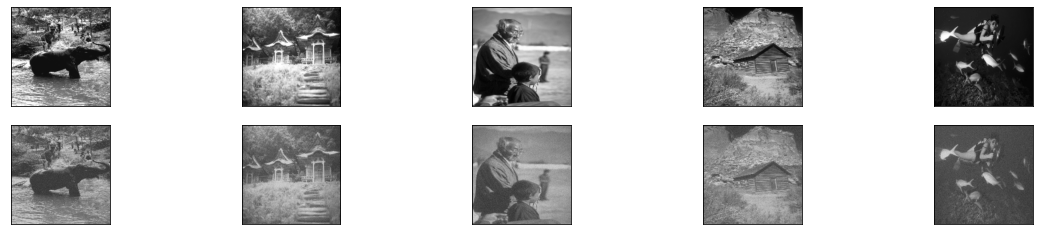

In [ ]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # present the orginal image
    ax = plt.subplot(2, n, i + 1)
    noisy_img, clean_img = process_path(pathlist[i])
    plt.imshow(clean_img, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # present the noisy image
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(noisy_img, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Question 10: Train your model with the trainning noisy dataset then evaluate the test set

In [ ]:
# Setup data by reading files for input and testing 
train_ds = tf.data.Dataset.list_files(str(data_dir+'train_noisy_color_images/*'))
test_ds = tf.data.Dataset.list_files(str(data_dir+'test_noisy_color_images/*'))

# Load up the files for the model
train_ds = train_ds.map(process_path)
test_ds = test_ds.map(process_path)

In [ ]:
model1 = CNN(depth=17, rate = 0.2, height=IMG_HEIGHT, width=IMG_WIDTH).model()

In [ ]:
model2 = DnCNN(depth=17).model()

In [ ]:
model3 = Self_encoder(depth=17, height=IMG_HEIGHT, width=IMG_WIDTH).model()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9)
loss_fn = tf.losses.mse

In [ ]:
model1.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])

model1.fit(train_ds,epochs=5,batch_size=BATCH_SIZE)

# test the model
test_noise,test_clean = next(iter(test_ds)) #Picking up a sample from test set
# Make a prediction using the model
prediction = model1.predict(test_noise)

!mkdir -p saved_model
model1.save('saved_model/my_model1')

Epoch 1/5


201/201 [==============================] - 241s 1s/step - loss: 0.0031 - accuracy: 0.0013
Epoch 2/5
201/201 [==============================] - 239s 1s/step - loss: 0.0025 - accuracy: 0.0013
Epoch 3/5
201/201 [==============================] - 239s 1s/step - loss: 0.0025 - accuracy: 0.0013
Epoch 4/5
201/201 [==============================] - 240s 1s/step - loss: 0.0026 - accuracy: 0.0013
Epoch 5/5
201/201 [==============================] - 239s 1s/step - loss: 0.0027 - accuracy: 0.0014


17/17 [==============================] - 1s 25ms/step


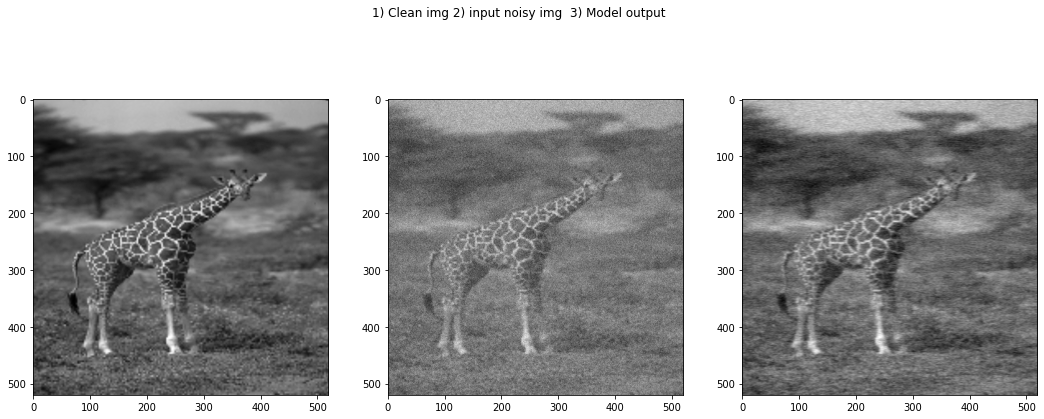

In [ ]:
#Plotting out all the 3 images
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(18,7))
fig.suptitle('1) Clean img 2) input noisy img  3) Model output' )
ax1.imshow(test_clean.numpy().reshape((test_noise.shape[0],test_noise.shape[1])) , cmap = 'gray')
ax2.imshow(test_noise.numpy().reshape((test_noise.shape[0],test_noise.shape[1])) ,  cmap='gray')
ax3.imshow(prediction.reshape((prediction.shape[0],prediction.shape[1])),cmap='gray', )

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9)
loss_fn = tf.losses.mse

In [ ]:
model2.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])

model2.fit(train_ds,epochs=10,batch_size=BATCH_SIZE)

# Lets now see how the model performs
test_noise,test_clean = next(iter(test_ds)) #Picking up a sample from test set
# Make a prediction using the model
prediction = model2.predict(test_noise)

model1.save('saved_model/my_model2')

Epoch 1/10
201/201 [==============================] - 98s 388ms/step - loss: 0.0016 - accuracy: 0.0014
Epoch 2/10
201/201 [==============================] - 81s 405ms/step - loss: 0.0016 - accuracy: 0.0014
Epoch 3/10
201/201 [==============================] - 84s 419ms/step - loss: 0.0016 - accuracy: 0.0014
Epoch 4/10
201/201 [==============================] - 80s 397ms/step - loss: 0.0016 - accuracy: 0.0014
Epoch 5/10
201/201 [==============================] - 84s 417ms/step - loss: 0.0015 - accuracy: 0.0014
Epoch 6/10
201/201 [==============================] - 85s 424ms/step - loss: 0.0015 - accuracy: 0.0014
Epoch 7/10
201/201 [==============================] - 81s 400ms/step - loss: 0.0015 - accuracy: 0.0014
Epoch 8/10
201/201 [==============================] - 85s 421ms/step - loss: 0.0015 - accuracy: 0.0014
Epoch 9/10
201/201 [==============================] - 80s 399ms/step - loss: 0.0015 - accuracy: 0.0014
Epoch 10/10
17/17 [==============================] - 1s 13ms/step


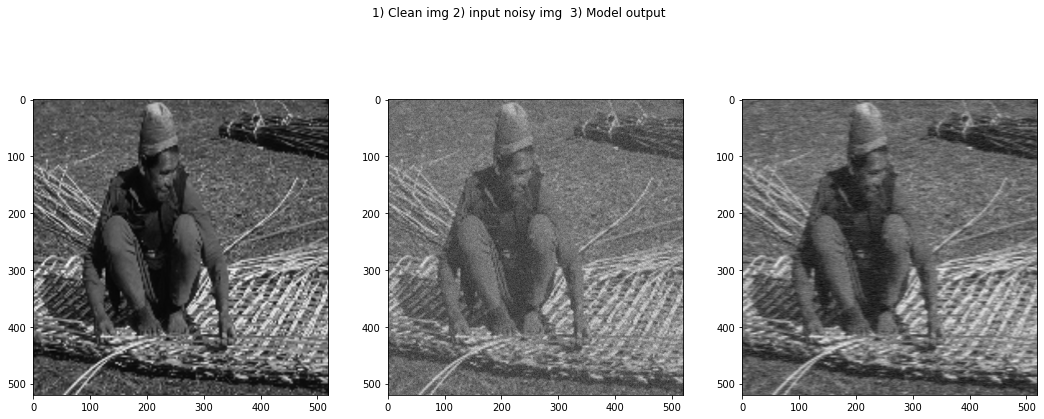

In [ ]:
#Plotting out all the 3 images
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(18,7))
fig.suptitle('1) Clean img 2) input noisy img  3) Model output' )
ax1.imshow(test_clean.numpy().reshape((test_noise.shape[0],test_noise.shape[1])) , cmap = 'gray')
ax2.imshow(test_noise.numpy().reshape((test_noise.shape[0],test_noise.shape[1])) ,  cmap='gray')
ax3.imshow(prediction.reshape((prediction.shape[0],prediction.shape[1])),cmap='gray', )

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9)
loss_fn = tf.losses.mse

In [ ]:
model3.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])

model3.fit(train_ds,epochs=10,batch_size=BATCH_SIZE)

# Lets now see how the model performs
test_noise,test_clean = next(iter(test_ds)) #Picking up a sample from test set
# Make a prediction using the model
prediction = model1.predict(test_noise)

model1.save('saved_model/my_model3')

Epoch 1/10


201/201 [==============================] - 93s 423ms/step - loss: 0.0027 - accuracy: 0.0014
Epoch 2/10
201/201 [==============================] - 88s 438ms/step - loss: 0.0019 - accuracy: 0.0014
Epoch 3/10
201/201 [==============================] - 88s 439ms/step - loss: 0.0019 - accuracy: 0.0014
Epoch 4/10
201/201 [==============================] - 86s 428ms/step - loss: 0.0019 - accuracy: 0.0014
Epoch 5/10
201/201 [==============================] - 85s 424ms/step - loss: 0.0019 - accuracy: 0.0014
Epoch 6/10
201/201 [==============================] - 88s 439ms/step - loss: 0.0019 - accuracy: 0.0014
Epoch 7/10
201/201 [==============================] - 89s 442ms/step - loss: 0.0018 - accuracy: 0.0014
Epoch 8/10
201/201 [==============================] - 89s 442ms/step - loss: 0.0018 - accuracy: 0.0014
Epoch 9/10
201/201 [==============================] - 87s 430ms/step - loss: 0.0018 - accuracy: 0.0014
Epoch 10/10
17/17 [==============================] - 0s 26ms/step


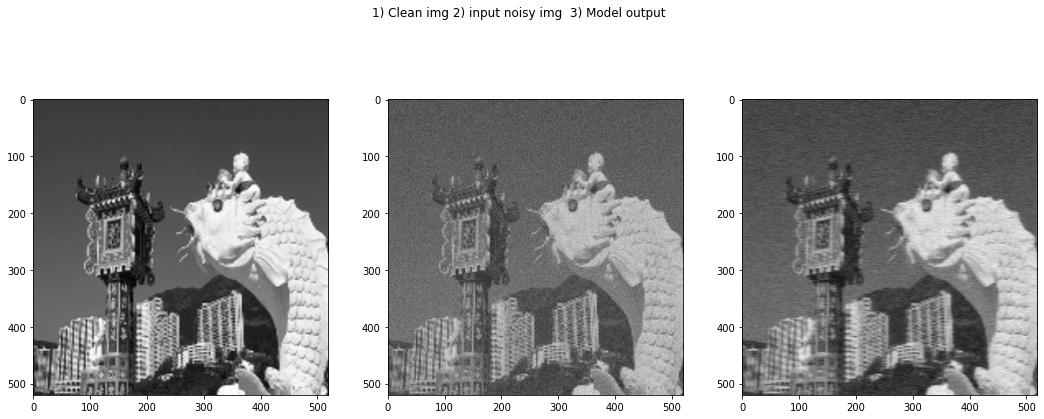

In [ ]:
#Plotting out all the 3 images
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(18,7))
fig.suptitle('1) Clean img 2) input noisy img  3) Model output' )
ax1.imshow(test_clean.numpy().reshape((test_noise.shape[0],test_noise.shape[1])) , cmap = 'gray')
ax2.imshow(test_noise.numpy().reshape((test_noise.shape[0],test_noise.shape[1])) ,  cmap='gray')
ax3.imshow(prediction.reshape((prediction.shape[0],prediction.shape[1])),cmap='gray', )

#### Question 11: Save your trained model so that you can use it to denoise an image without needing to retrain the network.

**Analysis：**Generally speaking, the three networks all have a certain denoising effect, but the noise of the picture is still very large, and the edge information of the picture is still relatively blurred. Since each network is only trained 5-10 times, the final effect is mediocre, and the network structure needs to be improved. We can change the hyperparameters, increase the number of training times, and add some smoothing layers to the network layer to make the output picture outline smoother. , thereby improving the noise reduction effect.